In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Corpus

We are working with the __[20 Newsgroup](http://qwone.com/~jason/20Newsgroups/)__ data set that comprises of about 20K newsgroup documents partitioned (almost) equally in 20 newsgroups.

The set of documents will be referred to as the corpus.

## Download

We first download all the documents.

In [0]:
from sklearn.datasets import fetch_20newsgroups

news_all = fetch_20newsgroups(subset='all')

## Data

We display the size of the corpus and the number of categories.

In [0]:
n_data = len(news_all.data)
n_target_names = len(news_all.target_names)

print("Newsgroup documents: ", n_data)
print("Newsgroups: ", n_target_names)

Newsgroup documents:  18846
Newsgroups:  20


The data is organized into the following newgroups. Each newsgroup represent a different topic.

In [0]:
news_all.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We display the number of documents for each topic.

In [0]:
from collections import Counter

import tabulate


def print_topics_count(news):
  topics_count = Counter([news.target_names[t] for t in news.target])

  table_topics_count = []

  for topic, count in topics_count.items():
    table_topics_count.append([topic, count])

  print(tabulate.tabulate(sorted(table_topics_count), 
                          headers = ['Topic', 'Count'],
                          tablefmt='simple'))
  
  return topics_count
  
_ = print_topics_count(news_all)


Topic                       Count
------------------------  -------
alt.atheism                   799
comp.graphics                 973
comp.os.ms-windows.misc       985
comp.sys.ibm.pc.hardware      982
comp.sys.mac.hardware         963
comp.windows.x                988
misc.forsale                  975
rec.autos                     990
rec.motorcycles               996
rec.sport.baseball            994
rec.sport.hockey              999
sci.crypt                     991
sci.electronics               984
sci.med                       990
sci.space                     987
soc.religion.christian        997
talk.politics.guns            910
talk.politics.mideast         940
talk.politics.misc            775
talk.religion.misc            628


# User profiles & topics

We create some user profiles with selected topics.

In [0]:
profiles = {
    "Arnau": ['rec.sport.baseball','rec.autos',],
    "Nasseredine": ['talk.politics.guns','sci.med'],
    "Jose Manuel": ['rec.autos', 'sci.electronics']
}

profiles

{'Arnau': ['rec.sport.baseball', 'rec.autos'],
 'Jose Manuel': ['rec.autos', 'sci.electronics'],
 'Nasseredine': ['talk.politics.guns', 'sci.med']}

We create a set of topics from these profiles.

In [0]:
topics_set = set()

for topics in profiles.values():
  topics_set.update(set(topics))
  
topics_set

{'rec.autos',
 'rec.sport.baseball',
 'sci.electronics',
 'sci.med',
 'talk.politics.guns'}

Finally we create a dictionnary that maps each topic to the profiles that contains it. This way we can forward a document of a given topic to the relevant users.

In [0]:
topics_profiles_dict = {}

for topic in topics_set:
    topics_profiles_dict[topic] = []
    
for user, topics in profiles.items():
    for topic in topics:
      topics_profiles_dict[topic].append(user)
      
topics_profiles_dict

{'rec.autos': ['Arnau', 'Jose Manuel'],
 'rec.sport.baseball': ['Arnau'],
 'sci.electronics': ['Jose Manuel'],
 'sci.med': ['Nasseredine'],
 'talk.politics.guns': ['Nasseredine']}

# Measure of similarity

In order to measure the similarity between a document and a topic we need to define vectors that will act as queries for the topics that our users are interested in.

## Documents

We first get the subset of documents whose category is in `topics_set`.

In [0]:
news_subset = fetch_20newsgroups(subset='all', categories=list(topics_set))

We check the number of documents we have in the subset.

The number of documents in the subset of the corpus will be referred to as `n_documents`.

In [0]:
n_documents = len(news_subset.data)

We make sure that we only have documents whose category is in `topics_set`.

In [0]:
news_subset.target_names

['rec.autos',
 'rec.sport.baseball',
 'sci.electronics',
 'sci.med',
 'talk.politics.guns']

We verify the number of document for each topic.

In [0]:
topics_subset_counts = print_topics_count(news_subset)

Topic                 Count
------------------  -------
rec.autos               990
rec.sport.baseball      994
sci.electronics         984
sci.med                 990
talk.politics.guns      910


## Queries

To define the queries we use topic dictionnaries to get some words related to a given topic.


Dictionnary used: [Oxford Learner's Dictionnaries](https://www.oxfordlearnersdictionaries.com/topic/)




In [0]:
topics_dict = { 
    # https://www.oxfordlearnersdictionaries.com/topic/driving
    'rec.autos': ["accelerate beep blind blind spot brake brake burn careen career carsick change down change up coast cruise cut in cut up dip drive drive drive away drive off drive on driving licence driving school driving test driving while intoxicated drop escort exhaust fill-up floor full beam gun handbrake turn handle handling high beams hitch hitchhike hold honk honk idle indicate lock L-plate motor navigate overtake pick up pillion priority provisional licence pull in pull off pull out pull over pull up purr ram reverse ride right of way road roadholding road map road sense road test road trip roar round rubber run screech service station slow speeding stall steer steering stop swerve tailgate tank up three-point turn traffic travel-sick truck truck stop turn turning turn-off turn off U-ey U-turn veer yield accelerator airbag air conditioning anti-roll bar armrest automatic transmission axle battery blinker body bodywork bonnet booster seat boot brake brake light brake pad bucket seat bumper carburettor car seat catalytic converter central locking chassis child restraint choke clock clutch coachwork combustion chamber crankshaft cruise control crumple zone cubbyhole dashboard decompressor dial dipstick dual controls electrics engine exhaust fan belt fender filler cap fin footbrake four-stroke front-wheel drive fuel injection gas gasoline gas pedal gear gearbox gear lever glove compartment go-faster stripes handbrake headlight headrest hood hooter horn hubcap ignition indicator internal-combustion engine legroom license plate L-plate manifold milometer mudflap muffler number plate odometer oil open-top paintwork passenger seat pedal petrol power steering radial radiator rear-view mirror rear-wheel drive roll bar roof roof rack satnav seat belt shock absorber spare tyre spark plug speedometer spoiler steering wheel stick shift strip stripped-down sunroof suspension tailgate tail light tank throttle tread trunk turn signal visor wheel wheel arch windscreen windscreen wiper windshield wing wing mirror wiper"],
    
    # https://www.oxfordlearnersdictionaries.com/topic/baseball
    'rec.sport.baseball': ["assist ball game ballhawk ballpark base baseball baseball cap baseline baseman bat batter big league box score brushback bullpen bunt catcher curve daisy cutter delivery diamond double play dugout fastball field fielding fireballer first base fly ball force-out forkball foul foul ball foul line grounder groundout hardball home plate home run inning kickball left field line drive Little League major league minor league out park pennant pinch-hit pitch pitchout right field run steal strike strikeout switch-hitter"],
    
    # https://www.oxfordlearnersdictionaries.com/topic/electronics
    'sci.electronics': ["AC ammeter amp amperage blow capacitor circuit circuit board condenser conduct conductor connect current DC diode disconnect earth earth electricity electric shock electrode electronic electronically electronics fuse insulated insulator microchip microelectronics ohm ohmmeter oscillate oscillator oscilloscope photoelectric relay resistance rewire semiconductor shock silicon chip solenoid switch transducer transformer transistor volt voltage voltmeter watt wattage wire"],
    
    # https://www.oxfordlearnersdictionaries.com/topic/complementary_medicine
    # https://www.oxfordlearnersdictionaries.com/topic/conventional_medicine
    'sci.med': ["acupressure acupuncture acupuncturist Alexander technique alternative medicine Ayurvedic medicine chiropractic chiropractor complementary medicine faith healing fringe medicine herbalism holism homeopathy hypnotherapy hypnotist iridology massage massage medicine man naturopathy osteopath osteopathy reflexology reiki shiatsu chemotherapy conventional day care dentistry general practice inpatient occupational therapy osteopathy outpatient pharmacy physiotherapy plastic surgery primary health care private psychiatry psychoanalysis psychotherapy radiotherapy rehab socialized medicine surgery therapy treatment"],
    
    # https://www.oxfordlearnersdictionaries.com/topic/weapons
    'talk.politics.guns':["airgun air pistol air rifle arrow automatic ballistic missile bayonet bazooka bomb bow broadsword cannon car bomb catapult cluster bomb crossbow cruise missile cutlass dagger dirty bomb firearm firebomb flamethrower grenade gun hand grenade handgun H-bomb hydrogen bomb incendiary Kalashnikov landmine letter bomb longbow machine gun mine missile Molotov cocktail mortar musket mustard gas nerve gas petrol bomb pistol ploughshare rapier revolver rifle rocket sawn-off shotgun shell small arms smoke bomb stun gun sub-machine gun sword tear gas torpedo truncheon water cannon weapon mass destruction"]
}

## Cosine similarity

We will use in this section, as a measure of similarity, the cosine measure.

The cosine similarity between a document and a query is computed as their normalized dot product:

$similarity(d,q) = cos(\theta) = \frac{d \cdot q^{T}}{\left\Vert d \right\Vert \space \left\Vert q \right\Vert} = \frac{\displaystyle\sum_{k=1}^{n} d_{k}q_{k}}{\sqrt{\displaystyle\sum_{k=1}^{n} d_{k}^{2}} \sqrt{\displaystyle\sum_{k=1}^{n} q_{k}^{2}}}$

We will use Scikit-Learn [cosine similarity](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) module in the [sklearn.metrics.pairwise](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise) submodule that computes pairwise distances.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

## Vector Space Model

We will use two different vector space models (also called term vector models) and see how they perform on our queries.



1.   Bag-of-words (BOW)
2.   Term frequency–inverse document frequency (TF-IDF)



### Bag-of-words

We first transform our documents using the *bag-of-words* vector representation.

Scikit-learn has a high level component which will create feature vectors for us: ‘CountVectorizer’.

This representation is build as follow:


1.   For each term (i.e. word) occuring in a document of the corpus collection, assign a fixed integer id. This can be done for example by building a dictionnary whose keys are the words and values are their ids.
2.   For each document $d_{i}$, count the number of occurences of each term (i.e. word) $t_{i,k}$ and store the feature (i.e. count) in `X[i, j]` where $j$ is the index of term $t_{j}$ in the dictionnary.

The dimension of the model will be referred to as `n_features`.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()

news_data_count_vectors = count_vectorizer.fit_transform(news_subset.data)

n_features = len(count_vectorizer.vocabulary_)

We display the words in the vocabulary.

In [0]:
count_vectorizer.vocabulary_

{'from': 22887,
 'myers': 34041,
 'hpfcso': 26002,
 'fc': 21748,
 'hp': 25981,
 'com': 15283,
 'bob': 11877,
 'subject': 45817,
 're': 40045,
 'scope': 42727,
 'questions': 39587,
 'organization': 35990,
 'hewlett': 25404,
 'packard': 36518,
 'fort': 22637,
 'collins': 15231,
 'co': 15057,
 'usa': 49617,
 'lines': 30569,
 '31': 3995,
 'if': 26531,
 'my': 34029,
 'life': 30460,
 'depended': 17901,
 'on': 35762,
 'it': 27960,
 'say': 42486,
 'that': 47211,
 'uses': 49645,
 'long': 30850,
 'persistance': 37288,
 'phosphor': 37503,
 'to': 47710,
 'keep': 29053,
 'the': 47221,
 'successive': 45918,
 'taces': 46600,
 'screen': 42797,
 'for': 22535,
 'some': 44487,
 'unit': 49285,
 'of': 35601,
 'time': 47585,
 'store': 45527,
 'them': 47241,
 'do': 18952,
 'get': 23553,
 'live': 30675,
 'we': 50977,
 'll': 30705,
 'let': 30319,
 'you': 52306,
 'but': 12764,
 'just': 28764,
 'this': 47374,
 'once': 35769,
 'there': 47275,
 'more': 33485,
 'real': 40083,
 'storage': 45525,
 'than': 47198,
 'pe

We display the dimensions of the matrix.

We check that the dimensions of the matrix are the following: `(n_documents, n_features)`.

In [0]:
print(news_data_count_vectors.shape == (n_documents, n_features), news_data_count_vectors.shape)

True (4868, 52650)


We create a *bag-of-words* document-term vector representation for each topic.

In [0]:
topic_counts = {}

for topic in topics_set:
  topic_counts[topic] = count_vectorizer.transform(topics_dict[topic])

We display the dimensions of the vectors.

We check that the dimensions of the vectors for each topic is the same as the learnt vocabulary: `(1, n_features)`

In [0]:
for topic in topics_set:
  print(topic_counts[topic].shape == (1, n_features), topic_counts[topic].shape)

True (1, 52650)
True (1, 52650)
True (1, 52650)
True (1, 52650)
True (1, 52650)


We compute the cosine similarity measure for each topic with all documents.

In [0]:
cos_sim_topics_counts = {}

for topic in topics_set:
  cos_sim_topics_counts[topic] = np.array(
      [cos[0] for cos 
       in cosine_similarity(news_data_count_vectors, topic_counts[topic])])

We rank the documents by the measure of similarity with respect to a query (the highest, the better).

In [0]:
def get_relevant_documents_percentage(cos_sim_topics, first_n_documents, topics=sorted(topics_set)):
  relevant_count_topics = {}

  for topic in topics:
    ind = np.argpartition(cos_sim_topics[topic], -first_n_documents)[-first_n_documents:]
    ind = ind[np.argsort(cos_sim_topics[topic][ind])]

    relevant_count = 0;
    for i in ind[::-1]:
       if news_subset.target_names[news_subset.target[i]] == topic:
          relevant_count += 1

    relevant_count_topics[topic] = relevant_count

  labels = list(relevant_count_topics.keys())
  relevant_documents_percentage = np.divide(np.array(list(relevant_count_topics.values())), first_n_documents) * 100
  
  return labels, relevant_documents_percentage

def plt_relevant_documents_percentage_bar(fig, ax, labels, relevant_documents_percentage):
  fig.suptitle("Percentage of relevant documents on the first {} results retrieved by topic".format(first_n_documents), fontsize=16)
    
  ax.bar(np.arange(len(labels)), relevant_documents_percentage, tick_label=labels)
  ax.set_ylabel("Relevant documents (%)", fontsize=14)
  ax.set_ylim(0, 100)
  ax.set_xlabel('Topic', fontsize=14)
  ax.set_xticklabels(labels, weight='semibold', fontsize=12)

  rects = ax.patches

  for rect, label in zip(rects, relevant_documents_percentage):
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2, height - 5, str(round(label, 2)) + '%',
              ha='center', color = 'white', weight='semibold', fontsize=14)

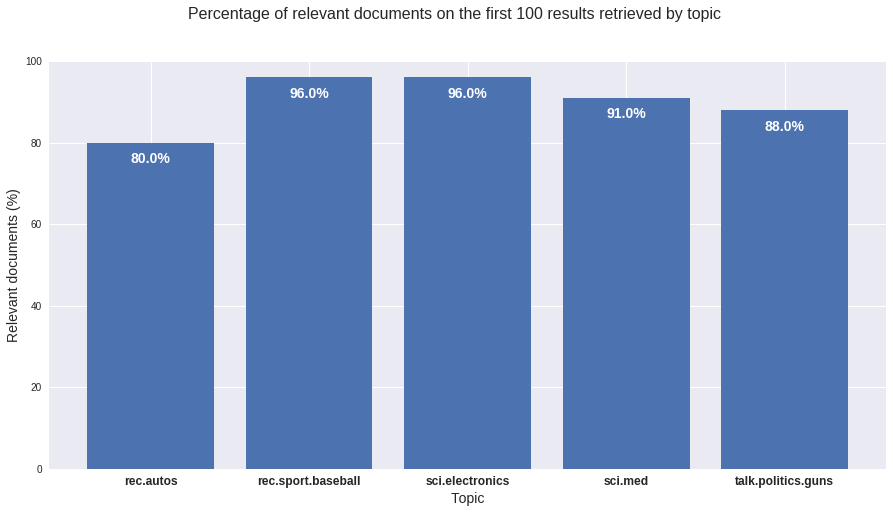

In [0]:
#@title  { run: "auto", form-width: "25%" }
first_n_documents = 100 #@param {type:"slider", min:1, max:900, step:1}

labels, relevant_documents_percentage_counts = get_relevant_documents_percentage(cos_sim_topics_counts, first_n_documents)

fig, ax = plt.subplots(figsize=(15,7.5))
plt_relevant_documents_percentage_bar(fig, ax, labels, relevant_documents_percentage_counts)
plt.show()

We have relatively good results for a small number of documents retrieved. However, we notice that the more documents retrieved and the lower the percentage of relevant document is, regarless of the topic.

Let's display this in a graph to visualize that.

In [0]:
def display_relevant_documents_percentage_line(fig, ax, cos_sim_topics, n_points=20, topics=sorted(topics_set)):
 
  for topic in topics:
    relevant_documents_percentages = []
    n_documents = np.vectorize(lambda x: int(round(x)))(np.linspace(1, topics_subset_counts[topic], n_points, endpoint=True))

    for n_document in n_documents:
      _, relevant_documents_percentage = get_relevant_documents_percentage(cos_sim_topics, int(round(n_document)), topics=[topic])
      relevant_documents_percentages.append(relevant_documents_percentage)

    ax.plot(n_documents, relevant_documents_percentages, label=topic)


  fig.suptitle("Percentage of relevant documents by number of retrieved documents".format(first_n_documents), fontsize=16)
  ax.set_ylabel("Relevant documents (%)", fontsize=14)
  ax.set_ylim(0, 100)
  ax.set_xlabel('Number of retrieved documents', fontsize=14)

  legend = ax.legend(title="Topics", loc='lower left', frameon=True, shadow=True, fontsize=14)
  legend.get_title().set_fontsize(16)
  legend.get_frame().set_facecolor('white')

The number of points `n_points` defines how smooth the graph will look.

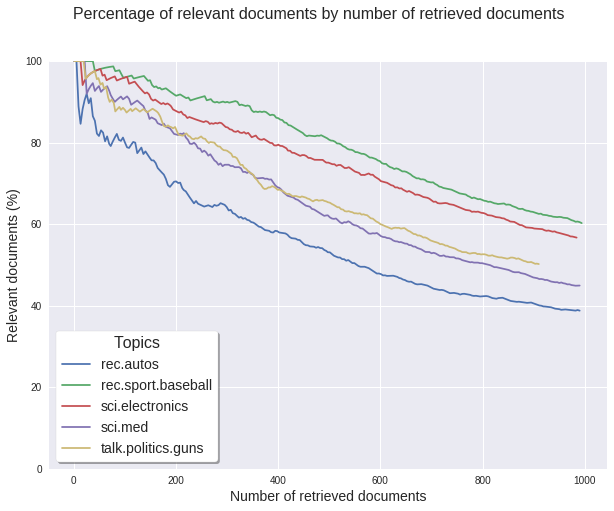

In [0]:
#@title  { run: "auto", form-width: "25%" }
n_points = 250 #@param {type:"slider", min:10, max:500, step:10}

fig, ax = plt.subplots(figsize=(10,7.5))
display_relevant_documents_percentage_line(fig, ax, cos_sim_topics_counts, n_points)

Indeed, the more document we retrieve and the lower the percentage of relevant document is. We have a relevance percentage above 80% for about up to 100 documents retrieved, regardless of the topic. However, retrieving the exact number of documents for each topic yields the worse results with accuracies from about 60% for the *rec.sport.baseball* topic to as low as about 40% for the topic *rec.autos*. This means that we are not able to retrieve all documents related to the topic, either because our query vectors are not exhaustive or because some words in the query vectors for a given topic might be found in other ones.

### TF-IDF

Just using the count of terms in each document has one important issue: it will give more weightage to longer documents than shorter ones. To avoid this, we can use the term frequency (TF), i.e. $ $, in each document. Also, we can even reduce the weightage of more common words like (the, is, an, etc...) which occurs in all document. This is called Term frequency-inverse document frequency or TF-IDF which is computed as $tfidf_{t,d,D} = tf_{t,d} \cdot idf_{t,D}$ where $idf_{t,D} = log \left(\frac{N}{|\{d \in D : t \in d\}| + 1}\right)$.

We first transform our documents using the *tf-idf* vector representation.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

news_data_tfidf_vectors = tfidf_vectorizer.fit_transform(news_subset.data)

n_features = len(tfidf_vectorizer.vocabulary_)

We check the dimensions of the matrix. The dimensions of the matrix is the following: `(n_documents, n_features)`.

In [0]:
print(news_data_tfidf_vectors.shape == (n_documents, n_features), news_data_tfidf_vectors.shape)

True (4868, 52650)


We create a *TF-IDF* representation for each topic.

In [0]:
topic_tfidfs = {}

for topic in topics_set:
  topic_tfidfs[topic] = tfidf_vectorizer.transform(topics_dict[topic])

We check that that the vectors size for each topic is the same as the learnt vocabulary: `(1, n_features)`

In [0]:
for topic in topics_set:
  print(topic_tfidfs[topic].shape == (1, n_features), topic_tfidfs[topic].shape)

True (1, 52650)
True (1, 52650)
True (1, 52650)
True (1, 52650)
True (1, 52650)


We compute the cosine similarity measure for each topic with all documents.

In [0]:
cos_sim_topics_tfidfs = {}

for topic in topics_set:
  cos_sim_topics_tfidfs[topic] = np.array(
      [cos[0] for cos 
       in cosine_similarity(news_data_tfidf_vectors, topic_tfidfs[topic])])

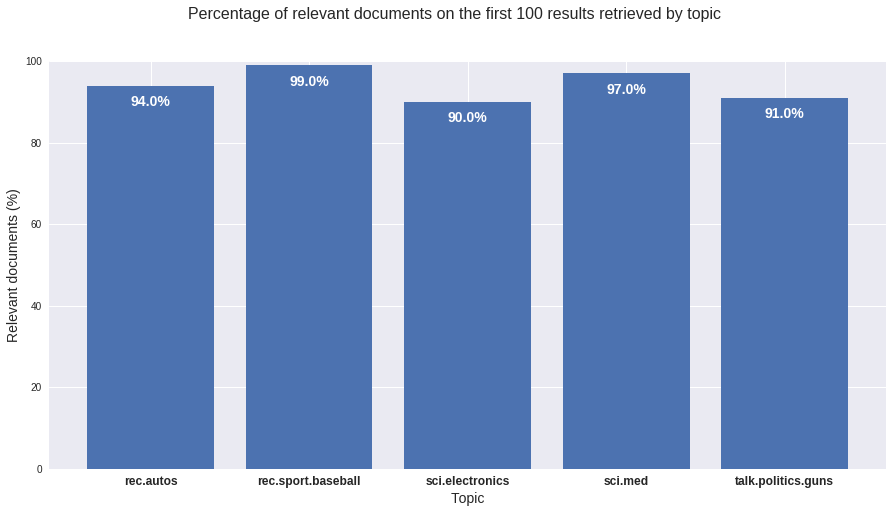

In [0]:
#@title  { run: "auto", form-width: "25%" }
first_n_documents = 100 #@param {type:"slider", min:1, max:900, step:1}

labels, relevant_documents_percentage_tfidfs = get_relevant_documents_percentage(cos_sim_topics_tfidfs, first_n_documents)

fig, ax = plt.subplots(figsize=(15,7.5))
plt_relevant_documents_percentage_bar(fig, ax, labels, relevant_documents_percentage_tfidfs)
plt.show()

We observe that we has sligthly better result than before. Let's display this on a graph to visualize this.

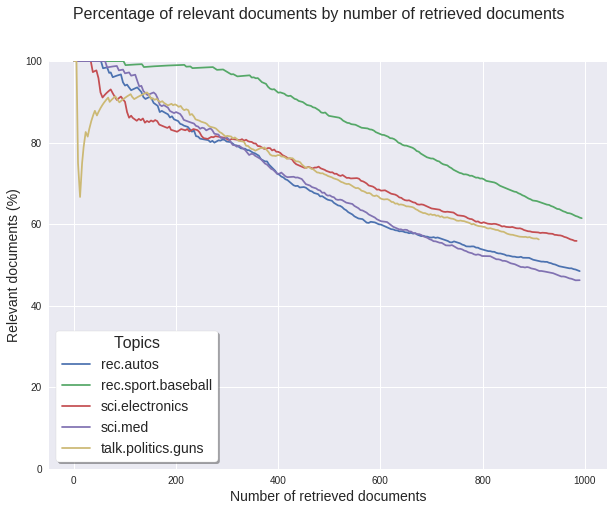

In [0]:
#@title  { run: "auto", form-width: "25%" }
n_points = 250 #@param {type:"slider", min:10, max:500, step:10}

fig, ax = plt.subplots(figsize=(10,7.5))
display_relevant_documents_percentage_line(fig, ax, cos_sim_topics_tfidfs, n_points)
plt.show()

It looks like we have improved the percentage of relevant documents for all topics compared to the BOW representation. However we can detect that for the topic `talk.politics.guns`, the percentage of relevant document suddenly drops at the beginning before increasing. This means that a non relevant document had a high score and was classified as being of that topic probably because it had some terms related to the query about `talk.politics.guns`.

### TF-IDF with square root

To correct the fact that some document retrieved are not from a the query topic because they may having some words about the topic, we apply a square root function to each elements in the query vectors, so that a document in order to be classified must have more words about the a given topic.

In [0]:
topic_tfidfs_sqrt = {}

for topic in topics_set:
  topic_tfidfs_sqrt[topic] = topic_tfidfs[topic].sqrt()
  
cos_sim_topics_tfidfs_sqrt = {}

for topic in topics_set:
  cos_sim_topics_tfidfs_sqrt[topic] = np.array(
      [cos[0] for cos 
       in cosine_similarity(news_data_tfidf_vectors, topic_tfidfs_sqrt[topic])])

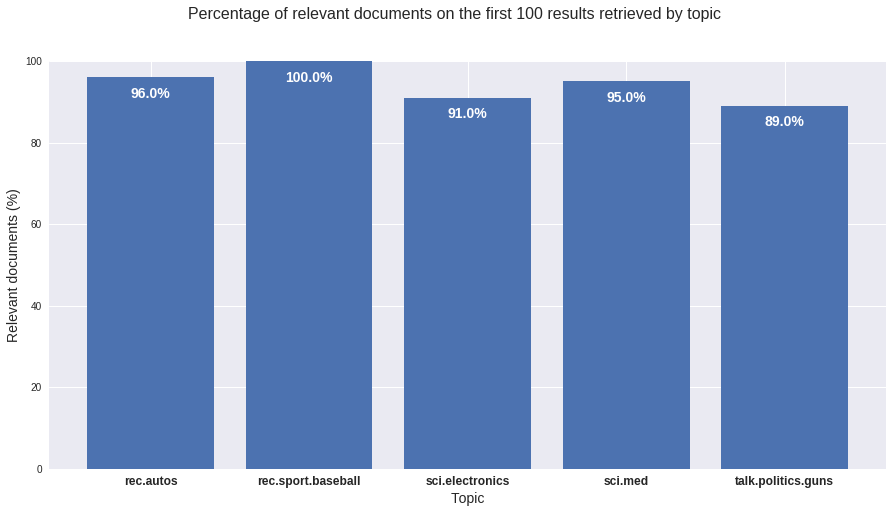

In [0]:
#@title  { run: "auto", form-width: "25%" }
first_n_documents = 100 #@param {type:"slider", min:1, max:900, step:1}

labels, relevant_documents_percentage_tfidfs_sqrt = get_relevant_documents_percentage(cos_sim_topics_tfidfs_sqrt, first_n_documents)

fig, ax = plt.subplots(figsize=(15,7.5))
plt_relevant_documents_percentage_bar(fig, ax, labels, relevant_documents_percentage_tfidfs_sqrt)
plt.show()

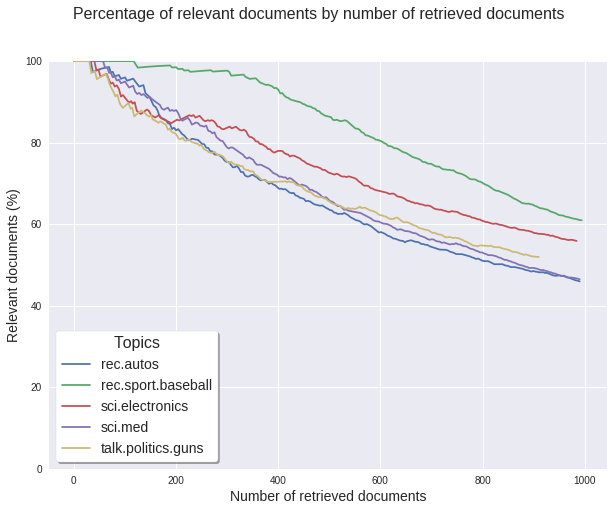

In [0]:
#@title  { run: "auto", form-width: "25%" }
n_points = 250 #@param {type:"slider", min:10, max:500, step:10}

fig, ax = plt.subplots(figsize=(10,7.5))
display_relevant_documents_percentage_line(fig, ax, cos_sim_topics_tfidfs_sqrt, n_points)
plt.show()

Indeed, applying the square root have solve the issue we had before.

### Comparison

Let's now compare the three methods used:



1.   BOW
2.   TF-IDF
3.   TF-IDF with square root (on query vectors)



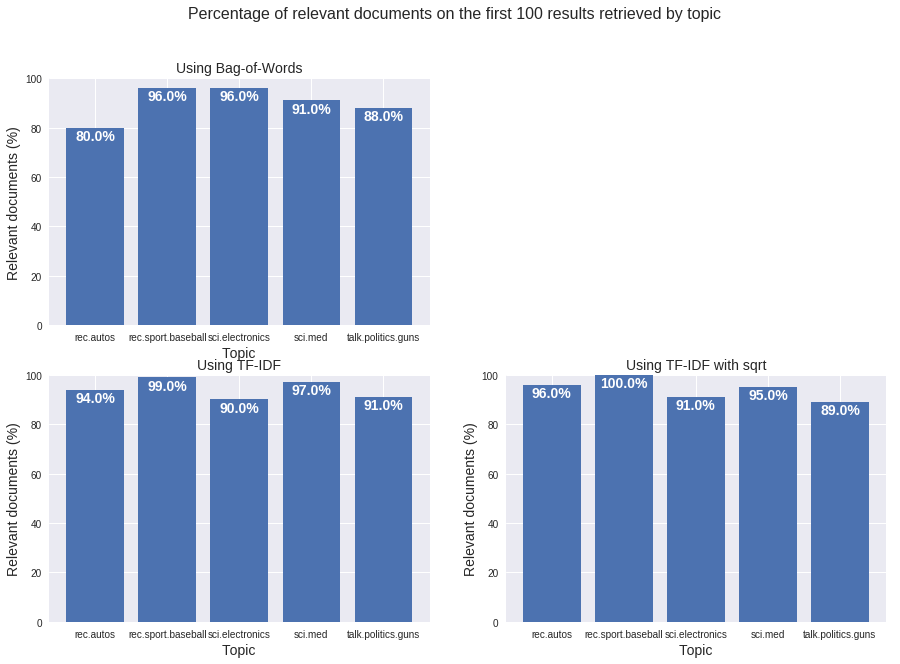

In [0]:
#@title  { run: "auto", form-width: "25%" }
first_n_documents = 100 #@param {type:"slider", min:1, max:900, step:1}

fig, ax = plt.subplots(2, 2, figsize=(15,10))
plt_relevant_documents_percentage_bar(fig, ax[0,0], labels, 
                                      get_relevant_documents_percentage(cos_sim_topics_counts, first_n_documents)[1])
ax[0,0].set_xticklabels(sorted(topics_set), weight = 'normal', fontsize = 10)
ax[0,0].set_title("Using Bag-of-Words", fontsize=14)
ax[0,1].axis('off')
plt_relevant_documents_percentage_bar(fig, ax[1,0], labels, 
                                      get_relevant_documents_percentage(cos_sim_topics_tfidfs, first_n_documents)[1])
ax[1,0].set_xticklabels(sorted(topics_set), weight = 'normal', fontsize = 10)
ax[1,0].set_title("Using TF-IDF", fontsize=14)
plt_relevant_documents_percentage_bar(fig, ax[1,1], labels, 
                                      get_relevant_documents_percentage(cos_sim_topics_tfidfs_sqrt, first_n_documents)[1])
ax[1,1].set_xticklabels(sorted(topics_set), weight = 'normal', fontsize = 10)
ax[1,1].set_title("Using TF-IDF with sqrt", fontsize=14)
plt.show()

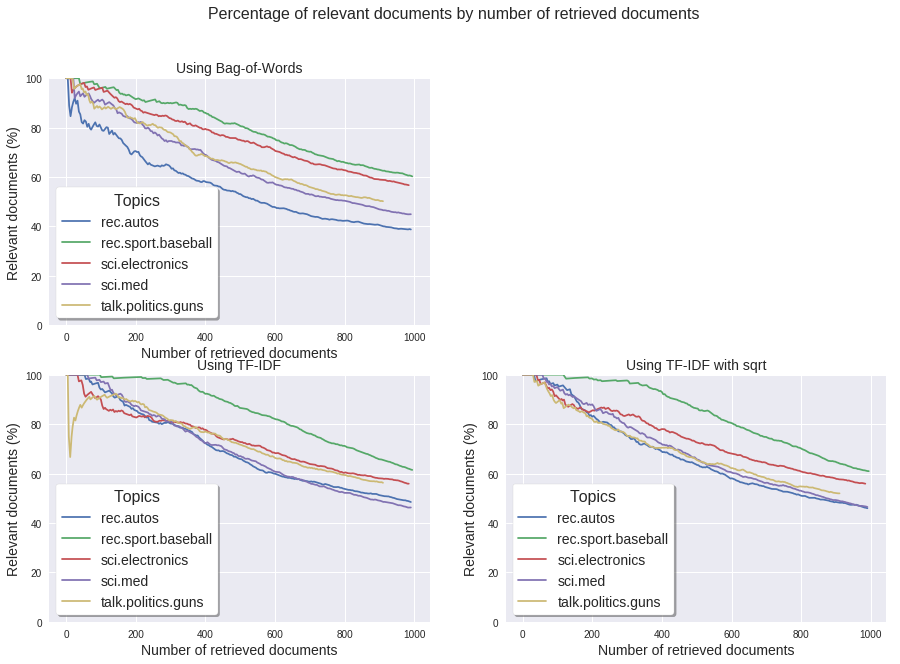

In [0]:
#@title  { run: "auto", form-width: "25%" }
n_points = 250 #@param {type:"slider", min:10, max:500, step:10}

fig, ax = plt.subplots(2, 2, figsize=(15,10))
display_relevant_documents_percentage_line(fig, ax[0,0], cos_sim_topics_counts, n_points)
ax[0,0].set_title("Using Bag-of-Words", fontsize=14)
ax[0,1].axis('off')
display_relevant_documents_percentage_line(fig, ax[1,0], cos_sim_topics_tfidfs, n_points)
ax[1,0].set_title("Using TF-IDF", fontsize=14)
display_relevant_documents_percentage_line(fig, ax[1,1], cos_sim_topics_tfidfs_sqrt, n_points)
ax[1,1].set_title("Using TF-IDF with sqrt", fontsize=14)
plt.show()

Indeed, we have improved with our latest methods. Let's focus on the first 200 as a user will unlikely go beyond (in a search engine, there is typically 10 results displayed per page, so 200 documents is 20 pages of results).

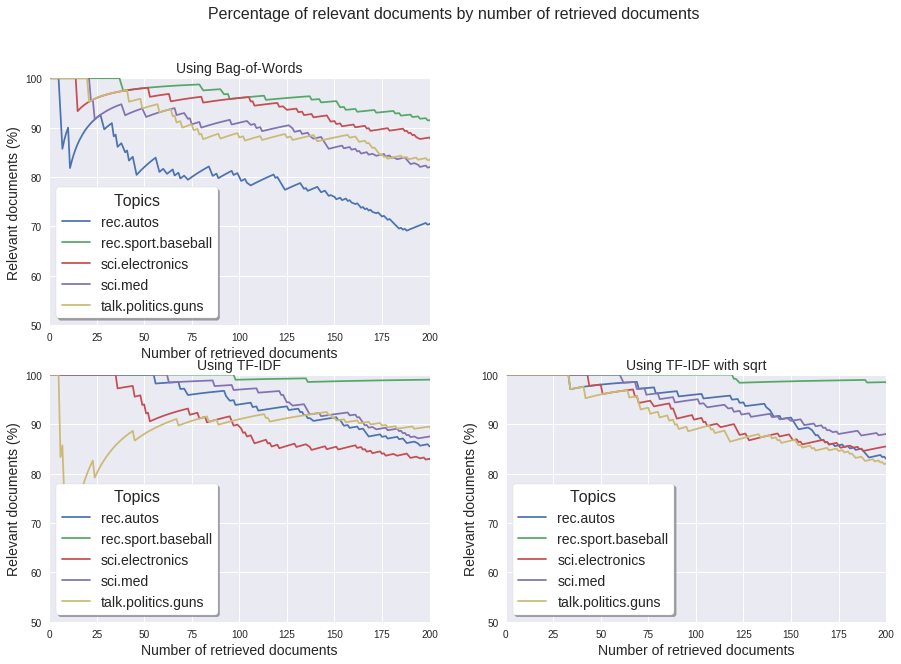

In [0]:
#@title  { run: "auto", form-width: "25%" }
first_n_documents = 200 #@param {type:"slider", min:10, max:500, step:10}
n_points = 900 #@param {type:"slider", min:10, max:900, step:10}

fig, ax = plt.subplots(2, 2, figsize=(15,10))
display_relevant_documents_percentage_line(fig, ax[0,0], cos_sim_topics_counts, n_points)
ax[0,0].set_title("Using Bag-of-Words", fontsize=14)
ax[0,0].set_xlim(0, first_n_documents)
ax[0,0].set_ylim(50, 100)
ax[0,1].axis('off')
display_relevant_documents_percentage_line(fig, ax[1,0], cos_sim_topics_tfidfs, n_points)
ax[1,0].set_title("Using TF-IDF", fontsize=14)
ax[1,0].set_xlim(0, first_n_documents)
ax[1,0].set_ylim(50, 100)
display_relevant_documents_percentage_line(fig, ax[1,1], cos_sim_topics_tfidfs_sqrt, n_points)
ax[1,1].set_title("Using TF-IDF with sqrt", fontsize=14)
ax[1,1].set_xlim(0, first_n_documents)
ax[1,1].set_ylim(50, 100)
plt.show()

With the last method we have overall better result and the percentage of relevant document decreases less rapidly.

# Machine Learning

The dataset we use have documents that are labelled. Hence, we would like to compare the approach of measuring the similarity between two vectors (document and query) with the one of using a learnt model using a Machine Learning algorithm.

## Load the data

We first load the training and testing data with the subset of documents whose category is in `topics_set`.

In [0]:
news_subset_train = fetch_20newsgroups(subset='train', categories=list(topics_set), remove=('headers', 'footers'), shuffle = True)
news_subset_test = fetch_20newsgroups(subset='test', categories=list(topics_set), remove=('headers', 'footers'), shuffle = True)

n_documents_train = len(news_subset_train.data)
n_documents_test = len(news_subset_test.data)

Number of training data.

In [0]:
len(news_subset_train.data)

2922

Number of testing data.

In [0]:
len(news_subset_test.data)

1946

## Bag-of-words

In [0]:
count_vectorizer = CountVectorizer()

news_subset_train_count = count_vectorizer.fit_transform(news_subset_train.data)

n_features = len(count_vectorizer.vocabulary_)

print(news_subset_train_count.shape == (n_documents_train, n_features), news_subset_train_count.shape)

True (2922, 37420)


In [0]:
news_subset_test_count= count_vectorizer.transform(news_subset_test.data)

print(news_subset_test_count.shape == (n_documents_test, n_features), news_subset_test_count.shape)

True (1946, 37420)


## TF-IDF

In [0]:
tfidf_vectorizer = TfidfVectorizer()

news_subset_train_tfidf = tfidf_vectorizer.fit_transform(news_subset_train.data)

n_features = len(tfidf_vectorizer.vocabulary_)

print(news_subset_train_tfidf.shape == (n_documents_train, n_features), news_subset_train_tfidf.shape)

True (2922, 37420)


In [0]:
news_subset_test_tfidf = tfidf_vectorizer.transform(news_subset_test.data)

print(news_subset_test_tfidf.shape == (n_documents_test, n_features), news_subset_test_tfidf.shape)

True (1946, 37420)


## Multinomial Naive Bayes

In [0]:
from sklearn.naive_bayes import MultinomialNB

mnb_clf_count = MultinomialNB()
mnb_clf_tfidf = MultinomialNB()

mnb_clf_count = mnb_clf_count.fit(news_subset_train_count, news_subset_train.target)
mnb_clf_tfidf = mnb_clf_tfidf.fit(news_subset_train_tfidf, news_subset_train.target)

In [0]:
predicted_count = mnb_clf_count.predict(news_subset_test_count)
predicted_tfidf = mnb_clf_tfidf.predict(news_subset_test_tfidf)

In [0]:
from sklearn import metrics

print('MNB with BOW')
print(metrics.accuracy_score(news_subset_test.target, predicted_count))

print(metrics.classification_report(news_subset_test.target, predicted_count,
                                    target_names=news_subset_test.target_names))


print('MNB with TF-IDF')
print(metrics.accuracy_score(news_subset_test.target, predicted_tfidf))

print(metrics.classification_report(news_subset_test.target, predicted_tfidf,
                                    target_names=news_subset_test.target_names))

MNB with BOW
0.9177800616649537
                    precision    recall  f1-score   support

         rec.autos       0.89      0.93      0.91       396
rec.sport.baseball       0.98      0.93      0.96       397
   sci.electronics       0.92      0.88      0.90       393
           sci.med       0.93      0.89      0.91       396
talk.politics.guns       0.87      0.96      0.91       364

       avg / total       0.92      0.92      0.92      1946

MNB with TF-IDF
0.9177800616649537
                    precision    recall  f1-score   support

         rec.autos       0.90      0.94      0.92       396
rec.sport.baseball       0.96      0.96      0.96       397
   sci.electronics       0.94      0.83      0.89       393
           sci.med       0.93      0.90      0.91       396
talk.politics.guns       0.85      0.97      0.91       364

       avg / total       0.92      0.92      0.92      1946



Using Multinomial Naive Bayes with either BOW or TF-IDF gives us the same global accuracy score. However the accuracy per topic differs.

## Support Vector Machine

In [0]:
from sklearn.linear_model import SGDClassifier
sgd_clf_count = SGDClassifier(max_iter=10000, tol=1e-3)
sgd_clf_tfidf = SGDClassifier(max_iter=10000, tol=1e-3)

sgd_clf_count = sgd_clf_count.fit(news_subset_train_count, news_subset_train.target)
sgd_clf_tfidf = sgd_clf_tfidf.fit(news_subset_train_tfidf, news_subset_train.target)

In [0]:
predicted_count = sgd_clf_count.predict(news_subset_test_count)
predicted_tfidf = sgd_clf_tfidf.predict(news_subset_test_tfidf)

In [0]:
print('SVM with BOW')
print(metrics.accuracy_score(news_subset_test.target, predicted_count))

print(metrics.classification_report(news_subset_test.target, predicted_count,
                                    target_names=news_subset_test.target_names))

print('SVM with TF-IDF')
print(metrics.accuracy_score(news_subset_test.target, predicted_tfidf))

print(metrics.classification_report(news_subset_test.target, predicted_tfidf,
                                    target_names=news_subset_test.target_names))

SVM with BOW
0.7995889003083247
                    precision    recall  f1-score   support

         rec.autos       0.77      0.56      0.65       396
rec.sport.baseball       0.89      0.89      0.89       397
   sci.electronics       0.71      0.85      0.77       393
           sci.med       0.78      0.84      0.81       396
talk.politics.guns       0.87      0.87      0.87       364

       avg / total       0.80      0.80      0.80      1946

SVM with TF-IDF
0.9157245632065776
                    precision    recall  f1-score   support

         rec.autos       0.90      0.91      0.91       396
rec.sport.baseball       0.93      0.96      0.95       397
   sci.electronics       0.90      0.90      0.90       393
           sci.med       0.92      0.87      0.89       396
talk.politics.guns       0.93      0.94      0.93       364

       avg / total       0.92      0.92      0.92      1946



Using SVM with TF-IDF gives better result than SVM with BOW. However it's similar to the previous approach of using MNB with BOW/TF-IDF.

## Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV

params_gs_sgd_clf_tfidf = {
    'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
}
  
gs_sgd_clf_tfidf =GridSearchCV(sgd_clf_tfidf, params_gs_sgd_clf_tfidf, n_jobs=-1)
gs_sgd_clf_tfidf = gs_sgd_clf_tfidf.fit(news_subset_train_tfidf, news_subset_train.target)

predicted_tfidf = gs_sgd_clf_tfidf.predict(news_subset_test_tfidf)

In [0]:
print(metrics.accuracy_score(news_subset_test.target, predicted_tfidf))

print(metrics.classification_report(news_subset_test.target, predicted_tfidf,
                                    target_names=news_subset_test.target_names))

0.9239465570400822
                    precision    recall  f1-score   support

         rec.autos       0.94      0.90      0.92       396
rec.sport.baseball       0.92      0.97      0.94       397
   sci.electronics       0.87      0.93      0.90       393
           sci.med       0.95      0.88      0.91       396
talk.politics.guns       0.94      0.94      0.94       364

       avg / total       0.93      0.92      0.92      1946



We've used here a grid search that improves a little the accuracy.



# Conclusion

We've tried two different approaches:


1.   Similarity measure on vector space models (BOW and TF-IDF) using the cosine similarity
2.   Machine Learning vector space models (BOW and TF-IDF) using
     
    *   Multinomial Naive Bayes
    *   Support Vector Machines


The first approach gave relatively goods results for a small number of documents retrieved (when using TF-IDF with square root on the queries: above 89% of relevant document for the first 100 results, above 82% for the first 200 results). However this score gets lower with a greater number of document retrieved. Using Machine Learning we have overall better accuary (above 90% using SVM with TF-IDF) in the task of classifying documents. However contrarily to the previous approach there is no way to rank the documents by their relevance. 

An approach mixing both techniques could be an interesting to explore. We could have also removed the stop words from the document and used stemming in order to improve both approaches.